In [1]:
# Step 1: Install Kaggle
!pip install kaggle

# Step 2: Upload Kaggle API Key (kaggle.json)
from google.colab import files
files.upload()  # Choose the kaggle.json file from your local system

# Step 3: Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 4: Download the Dataset
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

# Step 5: Unzip the Dataset
import zipfile
import os

# Create a directory for the dataset
dataset_dir = "deepfake_dataset"
os.makedirs(dataset_dir, exist_ok=True)

# Unzip the downloaded file
with zipfile.ZipFile("deepfake-and-real-images.zip", "r") as zip_ref:
    zip_ref.extractall(dataset_dir)

print(f"Dataset extracted to: {dataset_dir}")


Saving kaggle (2).json to kaggle (2).json
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
 99% 1.67G/1.68G [00:17<00:00, 112MB/s] 
100% 1.68G/1.68G [00:17<00:00, 102MB/s]
Dataset extracted to: deepfake_dataset


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import os


In [3]:
# Paths to dataset
dataset_dir = "deepfake_dataset/Dataset"
train_dir = os.path.join(dataset_dir, "Train")
val_dir = os.path.join(dataset_dir, "Validation")
test_dir = os.path.join(dataset_dir, "Test")

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to match ResNet input
    transforms.ToTensor(),         # Convert to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Pre-trained ResNet normalization
])

# Load datasets
train_data = datasets.ImageFolder(root=train_dir, transform=transform)
val_data = datasets.ImageFolder(root=val_dir, transform=transform)
test_data = datasets.ImageFolder(root=test_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Class names
class_names = train_data.classes
print(f"Classes: {class_names}")


Classes: ['Fake', 'Real']


In [4]:
# Load pre-trained ResNet18
resnet = models.resnet18(pretrained=True)

# Modify the final layer for binary classification
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, len(class_names))  # Number of output classes

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 152MB/s]


In [5]:
criterion = nn.CrossEntropyLoss()  # For classification
optimizer = optim.Adam(resnet.parameters(), lr=0.001)  # Use Adam optimizer


In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    model.train()  # Set model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Clear gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total * 100
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

        # Evaluate on validation set
        evaluate_model(model, val_loader)


In [10]:
def evaluate_model(model, loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    accuracy = correct / total * 100
    print(f"Validation Accuracy: {accuracy:.2f}%")


In [11]:
def test_model(model, loader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.show()


Epoch 1/5 - Loss: 0.1285, Accuracy: 94.89%
Validation Accuracy: 90.20%
Epoch 2/5 - Loss: 0.1022, Accuracy: 96.00%
Validation Accuracy: 94.79%
Epoch 3/5 - Loss: 0.0768, Accuracy: 97.00%
Validation Accuracy: 95.65%
Epoch 4/5 - Loss: 0.0638, Accuracy: 97.54%
Validation Accuracy: 95.15%
Epoch 5/5 - Loss: 0.0552, Accuracy: 97.83%
Validation Accuracy: 96.21%
Test Accuracy: 92.68%


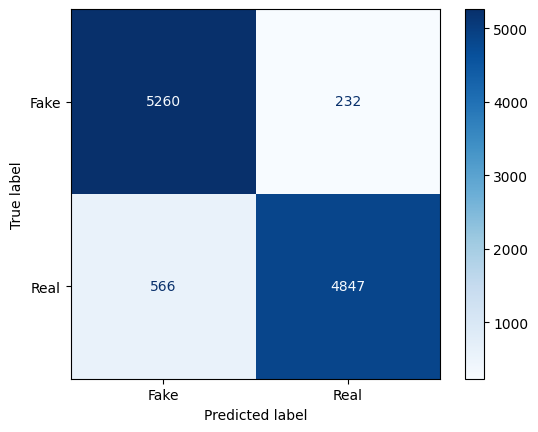

In [12]:
# Train the model
train_model(resnet, train_loader, val_loader, criterion, optimizer, epochs=5)

# Test the model
test_model(resnet, test_loader)
